In [35]:
#counts, bins, bars = plt.hist(x)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import optimize
import scipy

data = pd.read_csv('C:/Users/solom/Desktop/BAYES/dielectron.csv')

data = data.dropna()
data = data[(data['Q1'] + data['Q2']) == 0]

path = 'C:/Users/solom/Desktop/BAYES/'
path_plots = 'C:/Users/solom/Desktop/BAYES/Plots/'

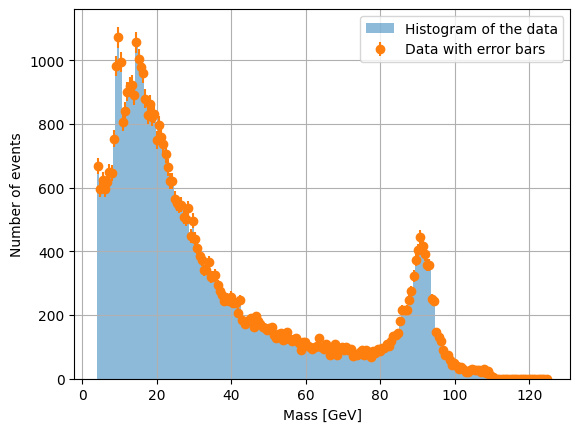

In [36]:
M_data = data['M'].values
#plt.hist(M_data, bins=200, range=(4, 125), alpha=0.5, label='Data')

y, bins, _ = plt.hist(M_data, bins=200, range=(4,125), alpha=0.5, label='Histogram of the data')
x = 0.5*(bins[1:]+bins[:-1])
y_errors = np.sqrt(y)  # Assuming Poisson statistics for the errors ----MAYBE ASK ABOUT THIS----

plt.errorbar(x, y, yerr=y_errors, fmt='o', label='Data with error bars')

plt.grid()
plt.xlabel('Mass [GeV]')
plt.ylabel('Number of events')

plt.legend()
plt.show()

counts = y
energies = x
counts_err = y_errors

In [37]:
#Try a poly-2 background fit model

def model(x, a1, mu1, sigma1, a2, mu2, sigma2, c0, c1, c2):
    gaussian1 = a1 * np.exp(-((x - mu1) ** 2) / (2 * sigma1 ** 2))
    gaussian2 = a2 * np.exp(-((x - mu2) ** 2) / (2 * sigma2 ** 2))
    background = c0 + c1 * x + c2 * x ** 2
    return gaussian1 + gaussian2 + background

In [38]:
def log_likelihood_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, c0, c1, c2, x, sigma_y):
    prediction = model(x, a1, mu1, sigma1, a2, mu2, sigma2, c0, c1, c2)

    n = len(y)
    # log of the PDF of a multivariate Gaussian
    return (
        -0.5 * np.sum((y - prediction)**2/sigma_y**2)  # Exponent
        - n/2*np.log(2*np.pi*sigma_y**2)               # Normalisation
    )

In [39]:
a1_prior = scipy.stats.norm(loc=410, scale=100)
mu1_prior = scipy.stats.norm(loc=91, scale=10)
sigma1_prior = scipy.stats.norm(loc=3, scale=3)

a2_prior = scipy.stats.norm(loc=700, scale=200)
mu2_prior = scipy.stats.norm(loc=15, scale=10)
sigma2_prior = scipy.stats.norm(loc=7.5, scale=3)

c0_prior = scipy.stats.norm(loc=0, scale=10)
c1_prior = scipy.stats.norm(loc=0, scale=1)
c2_prior = scipy.stats.norm(loc=0, scale=0.1)

def log_prior_probability(a1, mu1, sigma1, a2, mu2, sigma2, c0, c1, c2):
    return (a1_prior.logpdf(a1) + mu1_prior.logpdf(mu1) + sigma1_prior.logpdf(sigma1) +
            a2_prior.logpdf(a2) + mu2_prior.logpdf(mu2) + sigma2_prior.logpdf(sigma2) +
            c0_prior.logpdf(c0) + c1_prior.logpdf(c1) + c2_prior.logpdf(c2))


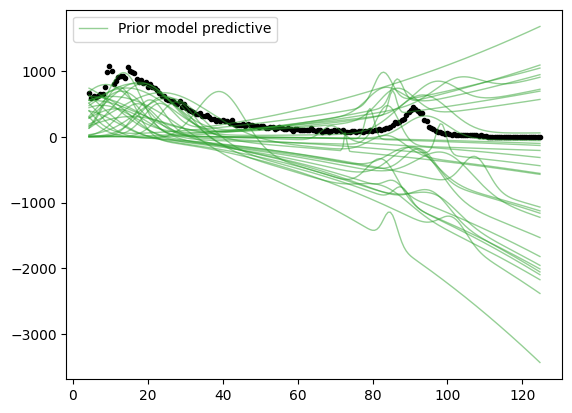

In [40]:
def sample_prior(n_sample):
    """Sample n_sample times from the prior distribution."""
    return np.vstack((a1_prior.rvs(n_sample), mu1_prior.rvs(n_sample), sigma1_prior.rvs(n_sample), a2_prior.rvs(n_sample),
                     mu2_prior.rvs(n_sample), sigma2_prior.rvs(n_sample), c0_prior.rvs(n_sample), c1_prior.rvs(n_sample), c2_prior.rvs(n_sample))).T

# Fix the pseudo random number generator seed for reproducibility
#np.random.seed(1)

# Evaluate the model at the prior sample parameters
prior_model_predictive = np.array(
    [model(x, *parameters) for parameters in sample_prior(n_sample=30)]
)



style = dict(c="C2", lw=1, alpha=0.5)
plt.plot(x, y, '.', color = 'black')
plt.plot(x, prior_model_predictive.T, **style)
plt.plot([], [], label="Prior model predictive", **style)
plt.legend()

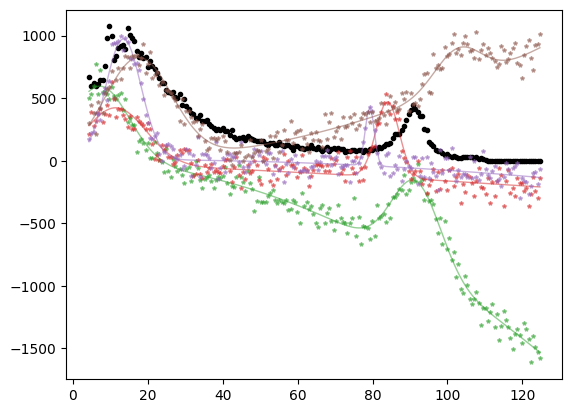

In [41]:
sigma_y = 70
prior_predictive = (
    prior_model_predictive
    + sigma_y*np.random.normal(size=prior_model_predictive.shape)
)

pmp_style = dict(lw=1, alpha=0.5)
pp_style = dict(ls="none", marker="*", ms=3, alpha=0.5)

plt.plot(x, y, ".", color = 'black')

for i in range(4):
    plt.plot(x, prior_model_predictive[i], c=f"C{i+2}", **pmp_style)
    plt.plot(x, prior_predictive[i], c=f"C{i+2}", **pp_style)

MAP results
[ 3.44042230e+02  9.08977786e+01  2.87884007e+00  8.40931248e+02
  1.41106569e+01  1.22236294e+01  1.15578494e+01  3.49217569e+00
 -3.07835292e-02]


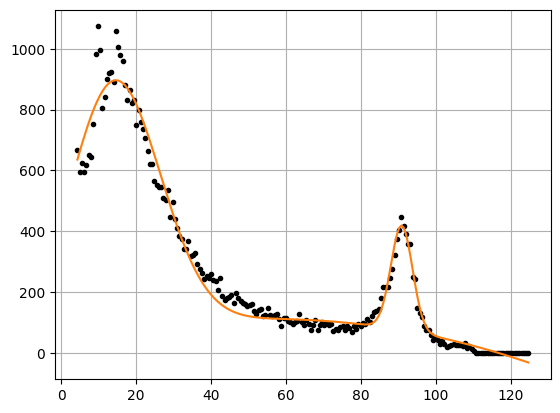

In [57]:
def log_posterior_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, c0, c1, c2, x, sigma_y):
    return (
        log_likelihood_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, c0, c1, c2, x, sigma_y)
        + log_prior_probability(a1, mu1, sigma1, a2, mu2, sigma2, c0, c1, c2)
    )
    
def negative_log_posterior(theta, x, sigma_y, y):
    a1, mu1, sigma1, a2, mu2, sigma2, c0, c1, c2 = theta
    return -log_posterior_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, c0, c1, c2, x, sigma_y)

MAP_result = scipy.optimize.minimize(
    fun=negative_log_posterior,
    x0=(410, 91, 3, 700, 15, 7.5, 12, 3.5, 0),
    args=(x, sigma_y, y)
)
MAP_results = MAP_result.x


print("MAP results")
print(MAP_results)
MAP_a1 = MAP_results[0]
MAP_mu1 = MAP_results[1]
MAP_sigma1 = MAP_results[2]
MAP_a2 = MAP_results[3]
MAP_mu2 = MAP_results[4]
MAP_sigma2 = MAP_results[5]
MAP_c0 = MAP_results[6]
MAP_c1 = MAP_results[7]
MAP_c2 = MAP_results[8]

plt.plot(x, y, '.', color = 'black')
plt.plot(x, model(x, *MAP_results), c="C1", label="MAP model")
plt.grid()
plt.savefig(path + '20241113_MAP_plot_with_poly_bg.png')

In [48]:
import emcee

# emcee passes an array of values for the sampled parameters
# This wrapper just splits the array theta into m and b
def log_posterior_wrapper(theta, x, sigma_y, y):
    a1, mu1, sigma1, a2, mu2, sigma2, c0, c1, c2 = theta
    return log_posterior_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, c0, c1, c2, x, sigma_y)

# emcee requires some extra settings to run
n_param = 9       # Number of parameter we are sampling
n_walker = 20     # Number of walkers. This just needs to be 
                  # larger than 2*n_param + 1!
n_step = 10000     # How many steps each walker will take. The number
                  # of samples will be n_walker*n_step

# The starting point for each walker
theta_init = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]) \
    + 0.1*np.random.normal(size=(n_walker, n_param))

sampler = emcee.EnsembleSampler(
    nwalkers=n_walker, ndim=n_param,
    log_prob_fn=log_posterior_wrapper,
    args=(x, sigma_y, y)
)
state = sampler.run_mcmc(theta_init, nsteps=n_step)

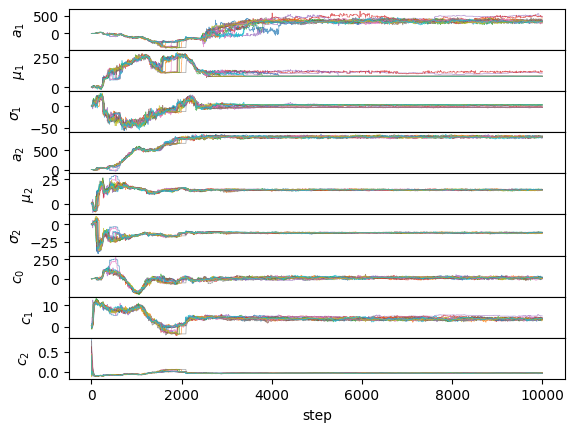

In [49]:
chain_per_walker = sampler.get_chain()
n_walker = 20
param_names = [r"$a_1$", r"$\mu_1$", r"$\sigma_1$", r"$a_2$", r"$\mu_2$", r"$\sigma_2$", r"$c_0$", r"$c_1$", r"$c_2$"]

# Plot the tracer of the chain, this time for all the walkers
fig, ax = plt.subplots(len(param_names), 1, sharex=True)
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walker):
        ax[i].plot(chain_per_walker[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name)

ax[-1].set_xlabel("step");

In [50]:
chain = sampler.get_chain(discard=7000, thin=10, flat=True)

In [51]:
print("Posterior results (mean±std)")
print(f"m = {np.mean(chain[:,0]):.2f}±{np.std(chain[:,0]):.2f}")
print(f"b = {np.mean(chain[:,1]):.2f}±{np.std(chain[:,1]):.2f}")

Posterior results (mean±std)
m = 355.17±45.06
b = 93.83±9.18


In [56]:
def plot_data_set(x, y, y_err):
    """Plot linear data set and format the plot."""
    fig, ax = plt.subplots(1, 1)

    if y_err is not None:
        ax.errorbar(x, y, y_err, fmt=".", label="Data")
    else:
        ax.plot(x, y, marker=".", linestyle="none", label="Data")

    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.legend(loc="upper left")

    return fig, ax

Using matplotlib backend: module://matplotlib_inline.backend_inline


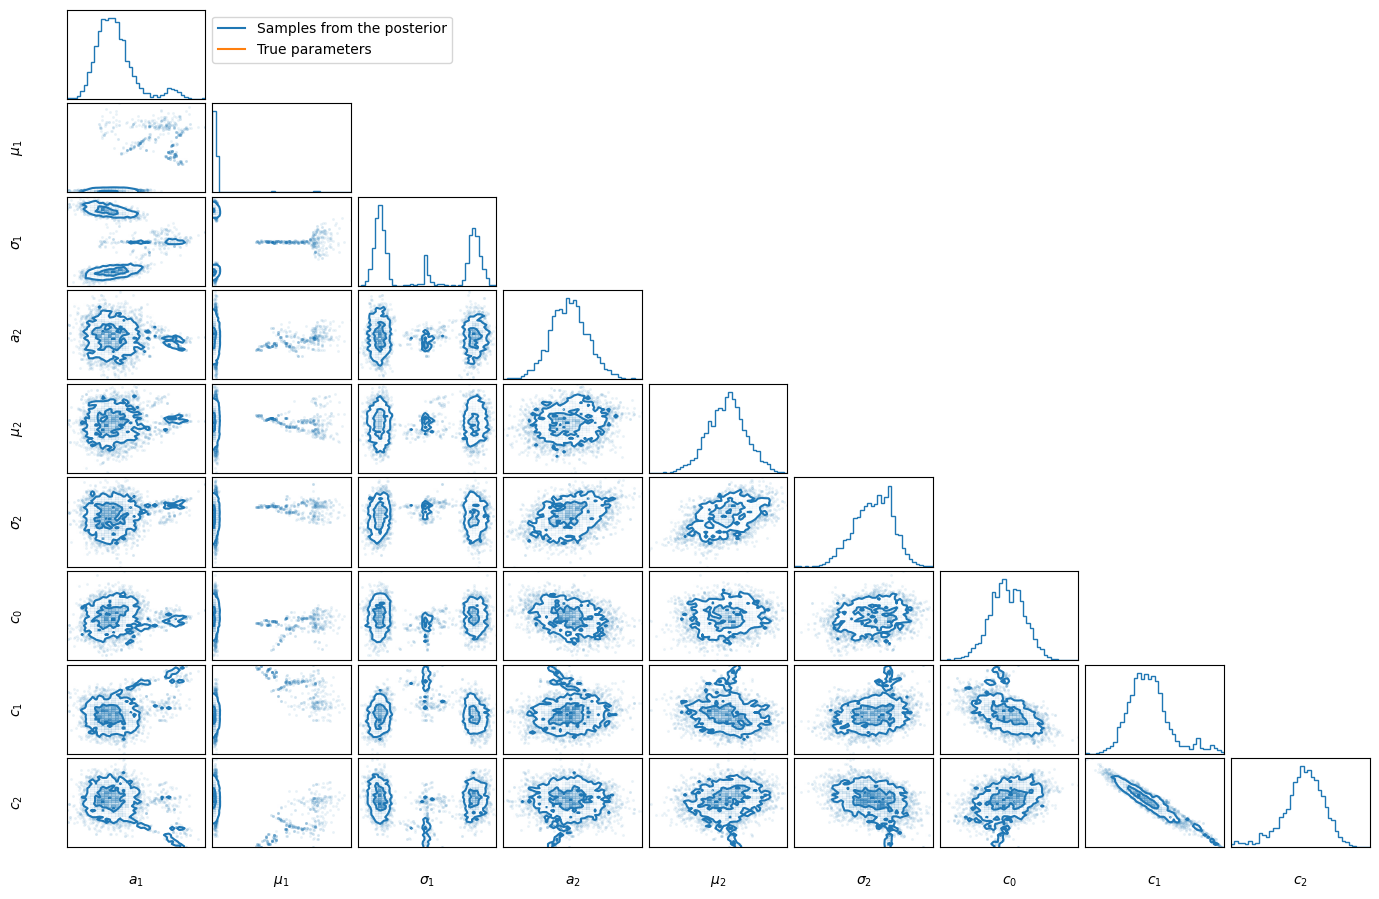

In [52]:
import corner
%matplotlib
fig = plt.figure()
fig = corner.corner(
    chain,
    bins=40,
    labels=[r"$a_1$", r"$\mu_1$", r"$\sigma_1$", r"$a_2$", r"$\mu_2$", r"$\sigma_2$", r"$c_0$", r"$c_1$", r"$c_2$"],
    color="C0",
    levels=1-np.exp(-0.5*np.array([1, 2])**2), # Credible contours corresponding
                                               # to 1 and 2 sigma in 2D
    # quantiles=[0.025, 0.16, 0.84, 0.975],
    fig=fig
)
fig.get_axes()[0].plot([], [], c="C0", label="Samples from the posterior")
fig.get_axes()[0].plot([], [], c="C1", label="True parameters")
fig.get_axes()[0].legend(loc=2, bbox_to_anchor=(1, 1))

# for ax in fig.get_axes():
#     ax.xaxis.label.set_size(12)  # Optional: Adjust font size if needed
#     ax.yaxis.label.set_size(12)
#     ax.xaxis.labelpad = 30       # Adjust label padding for x-axis
#     ax.yaxis.labelpad = 30       # Adjust label padding for y-axis

for ax in fig.get_axes():
    ax.tick_params(axis="both", which="both", length=0)  # Remove tick marks
    ax.set_xticklabels([])  # Remove x-axis tick labels
    ax.set_yticklabels([])  # Remove y-axis tick labels

fig.set_size_inches(14, 9)
plt.savefig(path + '20241123_corner_plot_gauss_poly_bg.png')


(0.0, 1200.0)

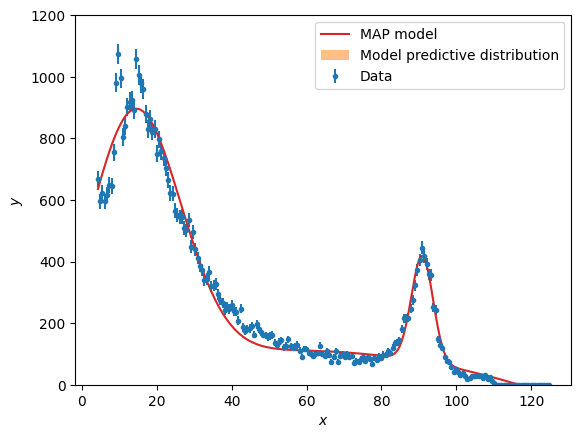

In [68]:
# Choose a small subsample of the chain for plotting purposes
chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
# Evaluate the model at the sample parameters
model_predictive = np.array(
[model(*sample, energies) for sample in chain_samples]
)
model_quantiles = np.quantile(
model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
)
# Because we have a Gaussian likelihood with variance \sigma_y^2, we can sample
# from the posterior predictive distribution by adding Gaussian noise with
# variance \sigma_y^2 to the model prediction samples
posterior_predictive = \
model_predictive + counts_err*np.random.normal(size=model_predictive.shape)

_, ax = plot_data_set(energies, counts, counts_err)

ax.plot(energies, model(energies, MAP_a1, MAP_mu1, MAP_sigma1, MAP_a2, MAP_mu2, MAP_sigma2, MAP_c0, MAP_c1, MAP_c2), c="C3", label="MAP model")
ax.fill_between(energies, model_quantiles[0], model_quantiles[-1], alpha=0.5, facecolor="C1",label="Model predictive distribution")
ax.fill_between(energies, model_quantiles[1], model_quantiles[-2], alpha=0.5, facecolor="C1")
ax.legend()
ax.set_ylim(0, 1200)